- KEYWORDS: numpy.linalg.solve, scipy.interpolate.interp1d, numpy.linalg.eigvals, numpy.linalg.eig, numpy.argsort



# Interpolating between data points



It is a common need to interpolate between data points, especially when we don't have knowledge of the function relating the data. There are a variety of approaches you can use for interpolation. We will consider a few approaches that use linear algebra here. Given $N$ points, construct an $N^{th}$ order polynomial that goes through all the points, and that can be used to estimate new values between the points.

First we consider some data.



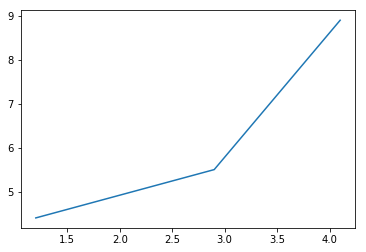

In [42]:
import numpy as np

x = np.array([1.2, 2.9, 4.1])
y = np.array([4.4, 5.5, 8.9])

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(x, y)

We would like an equation like $y(x) = a_2 x^2 + a_1 x + a_0$. If we write these out for each data point we get:

$y_0 = a_2 x_0^2 + a_1 x_0 + a_0$

$y_1 = a_2 x_1^2 + a_1 x_1 + a_0$

and so on. Here, the things we don't know are the parameters $\mathbf{a} [a_2, a_1, a_0]$. We can write these as:

$\mathbf{X} \mathbf{a} = \mathbf{y}$

Where $\mathbf{X} = [\mathbf{x^2}, \mathbf{x}, \mathbf{1}]$, and is called a Vandermonde matrix. We can readily create these with `numpy.vander`.



In [43]:
np.vander?

In [44]:
np.vander([2, 3, 4], 3)

array([[ 4,  2,  1],
       [ 9,  3,  1],
       [16,  4,  1]])

In [45]:
?np.stack

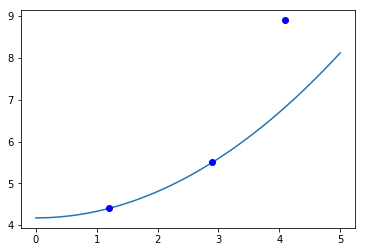

In [16]:
# You can build the X matrix by hand, which allows you to choose which pieces of the polynomial to include.
x1 = x[0:2]
X1 = np.stack([x1**2, x1**0], axis=1)
p1 = np.linalg.solve(X1, y[0:2])

x1fit = np.linspace(0, 5)
y1fit = np.stack([x1fit**2, x1fit**0], axis=1) @ p1
plt.plot(x1fit, y1fit, x, y, 'bo')

The first column is $x^2$, the second column is $x$, and the last column is all ones. To compute the polynomial coefficients, we just make the $\mathbf{X}$ array and solve the equations.



In [46]:
X = np.vander(x, 3)
a = np.linalg.solve(X, y)
a

array([ 0.75388776, -2.443881  ,  6.24705882])

In [47]:
np.polyfit(x, y, 2)

array([ 0.75388776, -2.443881  ,  6.24705882])

Now, we can use the parameters to compute new values.



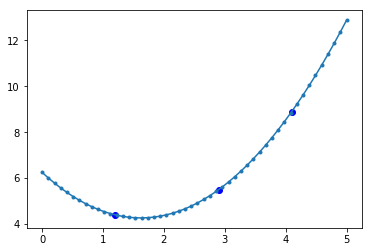

In [7]:
xfit = np.linspace(0, 5)
Y = np.vander(xfit, 3) @ a

plt.plot(x, y, 'bo', xfit, Y, '.-');

What we have done here is fit an N<sup>th</sup> order polynomial to $N$ data points. There is a possibility that we have overfit this data, and extrapolation is not reliable. However, interpolation by this method may be useful. We will return to this for larger data sets where $N$ is much larger than the order of the polynomial when we talk about linear regression next week.




## Interpolation libraries



There are several interpolating functions available in [scipy.interpolate](https://docs.scipy.org/doc/scipy/reference/interpolate.html). These are usually more flexible and convenient than writing your own interpolating code. They are more sophisticated, and have some *features* you should be aware of.



In [19]:
from scipy.interpolate import interp1d

interp1d?

Linear interpolation is the default, and we have to explicitly allow extrapolation.



In [33]:
xfit = np.linspace(0, 5)
Y = interp1d(x, y, bounds_error=False, fill_value="extrapolate")
Y(-20)

array(-9.317647058823525)

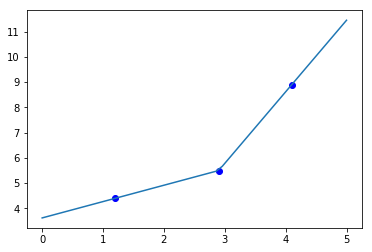

In [24]:
plt.plot(x, y, 'bo', xfit, Y(xfit));

We can also specify quadratic spline interpolation.



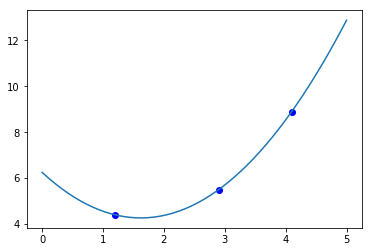

In [1]:
Y = interp1d(x, y, kind='quadratic', bounds_error=False, fill_value='extrapolate')

plt.plot(x, y, 'bo', X, Y(xfit));

With more data points you can also use cubic interpolation, which fits a cubic polynomial between the points, and ensures smoothness and continuity of the derivatives at the endpoints.

Note that you have to make some decisions about how to interpolate. These functions can introduce *wiggles* that are not real. Especially when there are step or sharp changes  in values.



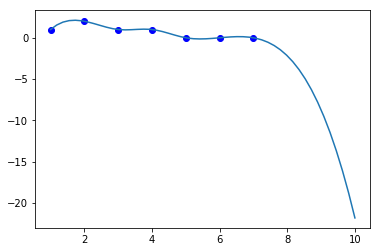

In [39]:
x = np.array([1, 2, 3, 4, 5, 6, 7])
y = np.array([1, 2, 1, 1, 0, 0, 0])

s = interp1d(x, y, kind='cubic', bounds_error=False, fill_value="extrapolate")
X = np.linspace(1, 10)
Y = s(X)

plt.plot(x, y, 'bo', X, Y)

Interpolation is a kind of data driven model for developing a mathematical model from data that can be used to predict new values. These models are not based on physics, but they can be used for predicting new values, estimating derivatives, integrals, etc. Of course, you must be careful with extrapolation; all polynomials tend to &plusmn; infinity eventually, which is probably not physically relevant in most cases.

There are multidimensional interpolation functions in `scipy.interpolate`,



In [40]:
??np.polyfit



# Eigenvalues



Eigenvalues and eigenvectors form an important class of linear algebra problems. They are an unusual class of problems though. Recall that we can interpret the equation $\mathbf{A}\mathbf{x} = \mathbf{b}$ as a linear transformation of the vector $\mathbf{x}$ into the vector $\mathbf{b}$. This will in general lead to rotation and stretching of the input vector. *Sometimes* though the new vector $\mathbf{b}$ is simply a rescaling of the original vector, i.e. $\mathbf{b} = \lambda \mathbf{x}$. &lambda; is the scaling factor, and it just changes the magnitude of the $\mathbf{x}$ vector. In this case, we call &lambda; an \eigenvalue\\, and $\mathbf{x}$ and \eigenvector\\ of the matrix $\mathbf{A}$.

When you see a problem in the form:

$\mathbf{A}\mathbf{x} = \lambda \mathbf{x}$

It is called an eigenvalue problem. It is conventional to write it in the following form:

$(\mathbf{A} - \lambda \mathbf{I})\mathbf{x} = \mathbf{0}$

Based on this equation, since $\mathbf{x}$ can be anything, it is necessary for the determinant of the matrix on the left to be zero. The eigenvalues of $\mathbf{A}$ are the ones that are solutions to

$det(\mathbf{A} - \lambda \mathbf{I}) = 0$

Computing the determinant leads to a *characteristic polynomial* in &lambda;, and the roots of this polynomial are the eigenvalues of the matrix.

For an $N \times N$ array there will be $N$ eigenvalues, although some may be degenerate. The eigenvalues can be real or complex. For some matrices, we know some properties of the eigenvalues. We will consider some of them here.

For example, the eigenvalues of a symmetric matrix are always real. We can make a symmetric matrix with some algebra:



In [58]:
A = np.random.rand(3,3)
A += A.T  # This makes a symmetric matrix
A

array([[ 0.66732883,  0.57462718,  0.89414352],
       [ 0.57462718,  1.39385151,  0.13850445],
       [ 0.89414352,  0.13850445,  1.61526968]])

We get the eigenvalues with `numpy.linalg.eigvals`.



In [59]:
np.linalg.eigvals(A)

array([-0.00503331,  2.34981233,  1.331671  ])

You can see these are all real.

The *trace* of a matrix is the sum of the diagonal elements. You can do this manually, or use `numpy.trace`.



In [1]:
np.sum(np.diag(A)), np.trace(A)

(2.8302306710535605, 2.8302306710535605)

It is a property that the sum of the eigenvalues is equal to the trace:

$trace \mathbf{A} = \sum \lambda_k$



In [1]:
np.sum(np.linalg.eigvals(A))

2.8302306710535627

It is also true that the product of the eigenvalues is equal to the determinant:

$det \mathbf{A} = \prod \lambda_k$



In [1]:
np.prod(np.linalg.eigvals(A)), np.linalg.det(A)

(-0.63229403451500454, -0.63229403451500354)

We can also see the eigenvectors. The `numpy.linalg.eig` function returns *both* eigenvalues and eigenvectors. The eigenvectors are in *columns*



In [92]:
e, v = np.linalg.eig(A)
e, v

(array([-0.00503331,  2.34981233,  1.331671  ]),
 array([[-0.84497635,  0.53373838, -0.03373868],
        [ 0.30349636,  0.42661766, -0.85199022],
        [ 0.44034636,  0.73015115,  0.52246949]]))

These eigenvectors have the property that the are normalized to unit length:



In [93]:
[np.linalg.norm(v[:, i]) for i in [0, 1, 2]]

[1.0, 1.0, 1.0]

The eigenvectors are in columns in the order corresponding to the order of the eigenvalues (these are not necessarily sorted). Here, we show that the eigenvalue/eigenvector pairs satisfy $\mathbf{A} \mathbf{v} = \lambda \mathbf{v}$.



In [94]:
[np.allclose(A @ v[:, 0], e[0] * v[:, 0]),
 np.allclose(A @ v[:, 1], e[1] * v[:, 1]),
 np.allclose(A @ v[:, 2], e[2] * v[:, 2])]

[True, True, True]

If you mix and match these, they do not satisfy the equations.



In [95]:
[np.allclose(A @ v[:, 0], e[1] * v[:, 2]),
 np.allclose(A @ v[:, 1], e[0] * v[:, 1]),
 np.allclose(A @ v[:, 2], e[2] * v[:, 0])]

[False, False, False]

Also, if you use the rows, it is not correct, and the equation is not satisfied.

In [96]:
[np.allclose(A @ v[0, :], e[0] * v[0, :]),
 np.allclose(A @ v[1, :], e[1] * v[1, :]),
 np.allclose(A @ v[2, :], e[2] * v[2, :])]

[False, False, False]

In [97]:
np.all(np.abs(A @ v[:, 2] - e[2] * v[:, 2]) < 1e-6)

True

In [98]:
np.all([True, True, False])

False

In [99]:
?np.allclose

The eigenvalues are not sorted. It is often useful to know the smallest, or largest eigenvalue, and to have the eigenvalues sorted. The tricky point to consider is the eigenvectors have to be sorted in the same order. It is also tricky that the eigenvectors are stored in columns, but sorting is done on rows. You can simply transpose the eigenvector array, sort on rows, and then transpose it back to columns.



In [100]:
i = np.argsort(e)
e[i]

array([-0.00503331,  1.331671  ,  2.34981233])

In [105]:
sorted_e = e[i]
sorted_v = v.T[i].T  # transpose to evecs in rows, sort, then back to evecs in columns.
sorted_e, sorted_v

(array([-0.00503331,  1.331671  ,  2.34981233]),
 array([[-0.84497635, -0.03373868,  0.53373838],
        [ 0.30349636, -0.85199022,  0.42661766],
        [ 0.44034636,  0.52246949,  0.73015115]]))

*As always* it is a good idea to check that we did not mess up:



In [107]:
for j, se in enumerate(sorted_e):
    sv = sorted_v[:, j]
    print(np.allclose(A @ sv, se * sv))

True
True
True



## Application to roots of a polynomial



The eigenvalues of a matrix are related to the roots of the characteristic polynomial of the matrix. We can leverage this to find the roots of a polynomial by constructing a matrix that has as its characteristic polynomial the polynomial we want the roots for. Then, the roots of the polynomial are just the eigenvalues of that matrix.

This example is adapted from [http://www.math.utah.edu/~gustafso/s2018/2270/labs/lab7-polyroot-qrmethod.pdf](http://www.math.utah.edu/~gustafso/s2018/2270/labs/lab7-polyroot-qrmethod.pdf)

First, we construct the *companion matrix*. For the polynomial $p(x) = a_0 + a_1 x + ... + a_{n-1} x^{n-1} + x^n$ we construct:

$C = \left[\begin{array}{ccccc}
 0 & 1 & 0 & ... & 0\\
 0 & 0 & 1 & ... & 0\\
 ... & ... & ... & \ddots & \vdots \\
 0 & 0 & 0 & ... & 1\\
 -a_0 & -a_1 & -a_2 & ... & -a_{n-1}
 \end{array}\right]$

Then, the eigenvalues of this matrix are equal to the roots of the polynomial. This matrix has ones on the diagonal above the main diagonal, and the coefficients up to the leading power on the bottom row. Note the coefficients are in the opposite order as we usually define them for `np.roots`.

The main diagonal has `N` elements in it, and the diagonal above that has `N-2` elements in it.

There are a few ways to reverse the coefficients, here we use `numpy.flipud` which reverses the elements.

Let $p(x) = 4 x^2 + 3x - 1$. We write the coefficient vector in the same order as used in np.roots.



It is implied in the companion matrix above that the coefficient on the leading power of x is 1. The companion matrix has a size of $N-1 \times N-1$

In [112]:
p = np.array([4, 3, -1])
N = len(p)

C = np.diag(np.ones(N - 2), 1)
C[-1, :] = np.flipud(-p[1:] / p[0])  # set the bottom row to the normalized paramaters where a_2 = 1
C

array([[ 0.  ,  1.  ],
       [ 0.25, -0.75]])

In [126]:
p, np.flipud(p), p[-1::-1]  # reversing the array

(array([ 4,  3, -1]), array([-1,  3,  4]), array([-1,  3,  4]))

Now the roots are found as the eigenvalues of the matrix.



In [115]:
r = np.linalg.eigvals(C)
r

array([ 0.25, -1.  ])

In [116]:
np.polyval(p, r)

array([ 0.,  0.])

In [118]:
np.vander(r, 3) @ p

array([ 0.,  0.])

This is essentially what the `np.roots` function does, although it uses a slightly different way to define the companion matrix.



In [127]:
import numpy as np
??np.roots

In [129]:
p = [4, 3, -1]
sorted(np.roots(p))

[-1.0, 0.25]

The order of the roots is not important; they may or may not be sorted.




## Applications to optimization



We can use eigenvalues to detect what kind of stationary point (f'(x) = 0) we are at. We have to know the [Hessian matrix](https://en.wikipedia.org/wiki/Hessian_matrix) at the stationary point. The eigenvalues of this matrix tell us about the stationary point.

1.  If all the eigenvalues are all positive, the matrix is called positive definite, and it means the stationary point is a minimum.
2.  If all the eigenvalues are negative, the matrix is called negative definite, and it means the stationary point is a maximum.
3.  If the signs of the eigenvalues are mixed then the stationary point is a saddle point.
4.  If there are zeros, it is inconclusive, and further analysis is needed.

Let's consider an example:



In [131]:
from scipy.optimize import minimize
def f(X):
    x, y = X
    return 2 * x**2 + 2 * x * y + 2 * y**2 - 6 * x

sol = minimize(f, [0, 0])
sol

      fun: -6.0
 hess_inv: array([[ 0.33333333, -0.16666667],
       [-0.16666667,  0.33333333]])
      jac: array([ 0.,  0.])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([ 1.99999999, -0.99999999])

We get an estimate of the inverse hessian here, so we convert it to a hessian first.



In [132]:
h = np.linalg.inv(sol['hess_inv'])
h

array([[ 3.99999998,  1.99999997],
       [ 1.99999997,  3.99999996]])

Now we check the eigenvalues:



In [133]:
np.linalg.eigvals(h)

array([ 5.99999994,  2.        ])

We have two positive eigenvalues, so the Hessian is positive definite, and we are at a minimum.

We can also use tools to compute the Hessian more directly (of course you can derive the partial derivatives by hand also):



In [ ]:
# You may need to run this to do the following block
!pip install Numdifftools

In [136]:
import numdifftools as nd
H = nd.Hessian(f)
print(H(sol.x))
np.linalg.eigvals(H(sol.x))

[[ 4.  2.]
 [ 2.  4.]]


array([ 2.,  6.])

Note the order of the eigenvalues is not important.

We will see more about numerical tools for computing Hessians and derivatives after Thanksgiving.




# Summary



Today we introduced the ideas behind interpolation which is a data-drive approach to model building that involves locally fitting functions to a few data points. We also introduced eigenvalues and eigenvectors, and some applications of how they are used.

Next week we will conclude linear algebra with linear regression.

